### Introduction

In the following notebook, I will be cleaning a raw data file of listings data from Inside Airbnb

**Read in libraries**

In [24]:
import numpy as np
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns

**Set notebook preferences**

In [25]:
#Set pandas preferences
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

**Read in data**

In [26]:
#Set path to data on local machine
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python\In Progress\Airbnb - San Francisco\Data\01_Raw\SF Airbnb'

#Read in data
df = pd.read_csv(path + '/2020_0519_Aggregated_Listings.csv',parse_dates= ['host_since','last_review', 'first_review'],index_col=0)

### Data Overview

**Preview Data**

In [27]:
#Display data, print shape
print('Data shape:', df.shape)
display(df.head(3))

Data shape: (113994, 106)


,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,country,country_code,description,experiences_offered,extra_people,first_review,guests_included,has_availability,host_about,host_acceptance_rate,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_picture_url,host_response_rate,host_response_time,host_since,host_thumbnail_url,host_total_listings_count,host_url,host_verifications,house_rules,id,instant_bookable,interaction,is_business_travel_ready,is_location_exact,jurisdiction_names,last_review,last_scraped,latitude,license,listing_url,longitude,market,maximum_maximum_nights,maximum_minimum_nights,maximum_nights,maximum_nights_avg_ntm,medium_url,minimum_maximum_nights,minimum_minimum_nights,minimum_nights,minimum_nights_avg_ntm,monthly_price,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,notes,number_of_reviews,number_of_reviews_ltm,picture_url,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,smart_location,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,*Full access to patio and backyard (shared wit...,3,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",25,106,43,58,1.0,Real Bed,1.0,2.0,1,1,0,0,2020-04-08,3 weeks ago,moderate,San Francisco,$100.00,United States,US,New update: the house next door is under const...,none,$25.00,2009-07-23,2,t,We are a family with 2 boys born in 2009 and 2...,98%,t,1169,t,t,1.0,"San Francisco, California, United States",Holly,Duboce Triangle,https://a0.muscache.com/im/pictures/user/efdad...,90%,within an hour,2008-07-31,https://a0.muscache.com/im/pictures/user/efdad...,1.0,https://www.airbnb.com/users/show/1169,"['email', 'phone', 'facebook', 'reviews', 'kba']",* No Pets - even visiting guests for a short t...,958,t,A family of 4 lives upstairs with their dog. N...,f,t,"{""SAN FRANCISCO""}",2020-03-13,2020-04-08,37.76931,STR-0001256,https://www.airbnb.com/rooms/958,-122.43386,San Francisco,1125,1,1125,1125.0,NaN,1125,1,1,1.0,"$4,200.00","Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Lower Haight,Western Addition,NaN,Due to the fact that we have children and a do...,240,56,https://a0.muscache.com/im/pictures/b7c2a199-4...,$170.00,Apartment,f,f,t,10.0,10.0,10.0,10.0,10.0,97.0,9.0,1.84,Entire home/apt,20200407152614,$100.00,"San Francisco, CA","Newly remodeled, modern, and bright garden uni...",NaN,CA,"San Francisco, CA, United States",New update: the house next door is under const...,NaN,*Public Transportation is 1/2 block away. *Ce...,"$1,120.00",NaN,94117
1,"Our deck, garden, gourmet kitchen and extensiv...",5,"{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",0,0,0,0,1.0,Real Bed,2.0,3.0,1,1,0,0,2020-04-09,2 weeks ago,strict_14_with_grace_period,San Francisco,$100.00,United States,US,We live in a large Victorian house on a quiet ...,none,$0.00,2009-05-03,2,t,Philip: English transplant to the Bay Area and...,81%,t,8904,t,f,2.0,"San Francisco, California, United States",Philip And Tania,Bernal Heights,https://a0.muscache.com/im/users/8904/profile_...,100%,within a day,2009-03-02,https://a0.muscache.com/im/users/8904/profile_...,2.0,https://www.airbnb.com/users/show/8904,"['email', 'phone', 'reviews', 'kba', 'work_ema...","Please respect the house, the art work, the fu...",5858,f,NaN,f,t,"{""SAN 

**View data description**

In [28]:
#View data description
df.describe().T

,count,mean,std,min,25%,50%,75%,max
accommodates,113994.0,3.149376e+00,1.909372e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
availability_30,113994.0,1.052719e+01,1.152965e+01,0.000000e+00,0.000000e+00,5.000000e+00,2.200000e+01,3.000000e+01
availability_365,113994.0,1.563405e+02,1.326936e+02,0.000000e+00,2.700000e+01,1.290000e+02,2.910000e+02,3.650000e+02
availability_60,113994.0,2.457436e+01,2.278379e+01,0.000000e+00,0.000000e+00,2.000000e+01,4.700000e+01,6.000000e+01
availability_90,113994.0,4.047330e+01,3.394188e+01,0.000000e+00,3.000000e+00,3.800000e+01,7.300000e+01,9.000000e+01
bathrooms,113854.0,1.389064e+00,9.092488e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.500000e+00,1.400000e+01
bedrooms,113948.0,1.340103e+00,9.356491e-01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+01
beds,113746.0,1.739991e+00,1.190063e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+01
calculated_host_listings_count,113994.0,2.513188e+01,6.085340e+01,1.000000e+00,1.000000e+00,2.000000e+00,1.100000e+01,3.010000e+02
calculated_host_listings_count_entire_homes,113994.0,2.056674e+01,5.867199e+01,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,3.010000e+02


## Data Cleaning

### Drop Columns

**Drop mostly homogenous/redundant columns and columns with only missing values**

In [29]:
#Extract cols with values with more than 1 unique value
df = df.loc[:,(df.nunique() != 1)]

In [30]:
#Drop missing columns
df.dropna(axis =1,how = 'all', inplace = True)

#Drop redundant columns
df.drop(['jurisdiction_names', 'market','state','neighbourhood','street','smart_location','host_neighbourhood'], axis = 1, inplace = True)

In [31]:
#Inspect cols with <=2 unique values
inspect = df.loc[:, (df.nunique() <=2)].columns.to_list()

#Check
display(df[inspect].head(3))

,host_has_profile_pic,host_identity_verified,host_is_superhost,instant_bookable,is_location_exact,require_guest_phone_verification,require_guest_profile_picture,requires_license
0,t,t,t,t,t,f,f,t
1,t,t,f,f,t,f,f,t
2,t,t,f,f,t,f,f,t


In [32]:
#Create dictionary for mapping
mapping = {'t':1,'f':0}

#Map 1's and 0's on t's and f's
df[inspect] = df[inspect].apply(lambda x: x.map(mapping, na_action='ignore'))

#Check
display(df[inspect].head(3))

,host_has_profile_pic,host_identity_verified,host_is_superhost,instant_bookable,is_location_exact,require_guest_phone_verification,require_guest_profile_picture,requires_license
0,1.0,1.0,1.0,1,1,0,0,1
1,1.0,1.0,0.0,0,1,0,0,1
2,1.0,1.0,0.0,0,1,0,0,1


**Drop columns containing url data or pertain to webscraping**

In [33]:
#Subset column headers containing 'url' or 'scrape' and store in drop
drop = list(df.filter(regex='url|scrape').columns)

#Drop drop list and check
df.drop(columns= df[drop], inplace=True)
df.head(1)

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_acceptance_rate,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_response_rate,host_response_time,host_since,host_total_listings_count,host_verifications,house_rules,id,instant_bookable,interaction,is_location_exact,last_review,latitude,license,longitude,maximum_maximum_nights,maximum_minimum_nights,maximum_nights,maximum_nights_avg_ntm,minimum_maximum_nights,minimum_minimum_nights,minimum_nights,minimum_nights_avg_ntm,monthly_price,name,neighborhood_overview,neighbourhood_cleansed,notes,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,space,square_feet,summary,transit,weekly_price,zipcode
0,*Full access to patio and backyard (shared wit...,3,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",25,106,43,58,1.0,Real Bed,1.0,2.0,1,1,0,0,3 weeks ago,moderate,San Francisco,$100.00,New update: the house next door is under const...,$25.00,2009-07-23,2,We are a family with 2 boys born in 2009 and 2...,98%,1.0,1169,1.0,1.0,1.0,"San Francisco, California, United States",Holly,90%,within an hour,2008-07-31,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",* No Pets - even visiting guests for a short t...,958,1,A family of 4 lives upstairs with their dog. N...,1,2020-03-13,37.76931,STR-0001256,-122.43386,1125,1,1125,1125.0,1125,1,1,1.0,"$4,200.00","Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Western Addition,Due to the fact that we have children and a do...,240,56,$170.00,Apartment,0,0,1,10.0,10.0,10.0,10.0,10.0,97.0,9.0,1.84,Entire home/apt,$100.00,"Newly remodeled, modern, and bright garden uni...",NaN,New update: the house next door is under const...,*Public Transportation is 1/2 block away. *Ce...,"$1,120.00",94117


## Check for high correlations between features

**Prepare data**

In [34]:
#Create correlation matrix and capture absolute values of correlations
c = df.corr().abs()

#Create a df that stores correlations between features >.9
s = c.unstack()
so = s.sort_values(kind="quicksort").reset_index()
so.columns = ['feat1','feat2','corr']
so = so.loc[ (so.feat1 != so.feat2 )& (so['corr'] > .9)]

#Capture list of features
feats =so.feat1.unique()

#Subset df by cols in feats and create corr
corr= df[feats].corr()

**Create heatmap**

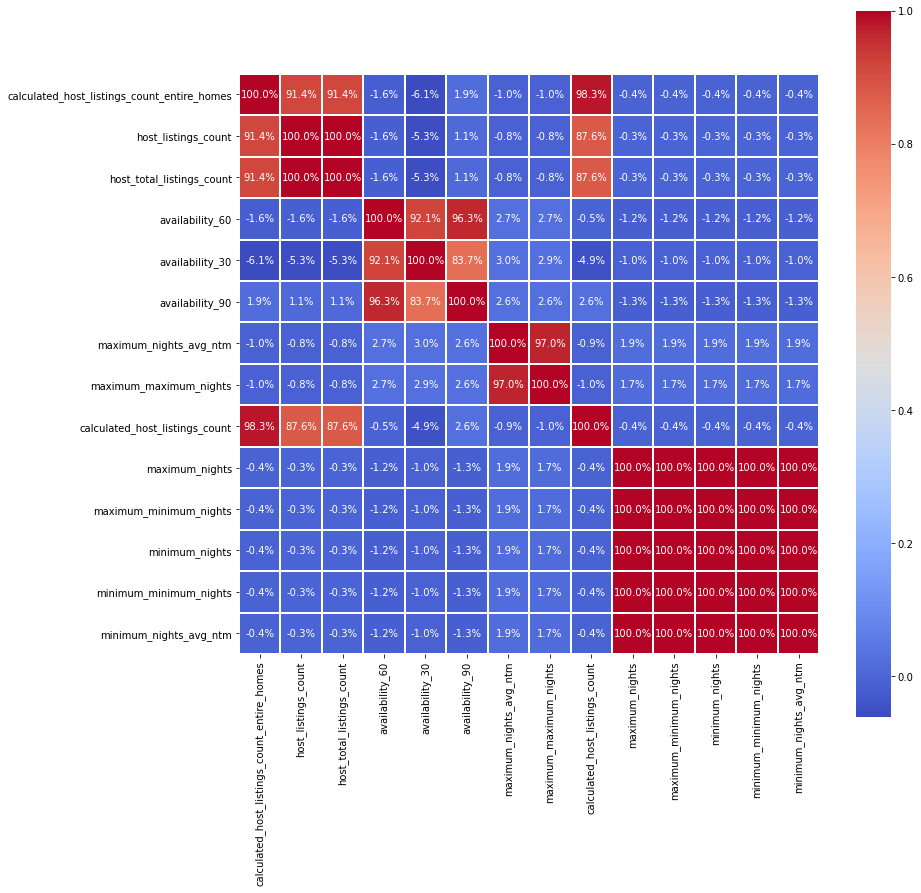

In [35]:
#Create fig
f, ax = plt.subplots(figsize = (13,13))

#Plot corr as heat map
sns.heatmap(data = corr, annot=True,fmt='.1%', cmap = 'coolwarm', ax=ax,
            linewidths=1.0, square=1);

**Drop cols with high collinearity**

In [36]:
#Cols with high collinearity
drop = ['calculated_host_listings_count_entire_homes','maximum_nights_avg_ntm', 'maximum_maximum_nights','minimum_maximum_nights',
        'maximum_minimum_nights','minimum_minimum_nights', 'minimum_nights_avg_ntm', 'host_total_listings_count']

#Drop drop
df.drop(drop, axis=1, inplace = True)

## Clean up object and numeric columns

**Clean up numeric columns**

In [37]:
#Filter cols pertaining to prices and assign col names as a list to money_cols
money_cols = df.filter(regex = 'people|deposit|price|fee$|rate').columns.tolist()

#Remove $, and set type as numeric for money_cols
df[money_cols] = df[money_cols].replace('[$|,|%]','',regex = True).astype('float')

#Check
display(df[money_cols].head(3))

,cleaning_fee,extra_people,host_acceptance_rate,host_response_rate,monthly_price,price,security_deposit,weekly_price
0,100.0,25.0,98.0,90.0,4200.0,170.0,100.0,1120.0
1,100.0,0.0,81.0,100.0,5500.0,235.0,NaN,1600.0
2,50.0,12.0,86.0,100.0,1685.0,65.0,200.0,485.0


**Filter price such that all values are > 0**

In [38]:
#How many rows have price == 0? Remove
print('Number of rows with price is $0: {}'.format(len(df.loc[df.price == 0])))
df = df.loc[~(df.price == 0)]

Number of rows with price is $0: 18


**Clean up object columns**

In [39]:
#Create list of columns to apply cleaning to
objects = df.select_dtypes('object').columns.to_list()

#Check
display(df[objects].head(3))

,access,amenities,bed_type,calendar_updated,cancellation_policy,city,description,host_about,host_location,host_name,host_response_time,host_verifications,house_rules,interaction,license,name,neighborhood_overview,neighbourhood_cleansed,notes,property_type,room_type,space,summary,transit,zipcode
0,*Full access to patio and backyard (shared wit...,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",Real Bed,3 weeks ago,moderate,San Francisco,New update: the house next door is under const...,We are a family with 2 boys born in 2009 and 2...,"San Francisco, California, United States",Holly,within an hour,"['email', 'phone', 'facebook', 'reviews', 'kba']",* No Pets - even visiting guests for a short t...,A family of 4 lives upstairs with their dog. N...,STR-0001256,"Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Western Addition,Due to the fact that we have children and a do...,Apartment,Entire home/apt,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,*Public Transportation is 1/2 block away. *Ce...,94117
1,"Our deck, garden, gourmet kitchen and extensiv...","{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",Real Bed,2 weeks ago,strict_14_with_grace_period,San Francisco,We live in a large Victorian house on a quiet ...,Philip: English transplant to the Bay Area and...,"San Francisco, California, United States",Philip And Tania,within a day,"['email', 'phone', 'reviews', 'kba', 'work_ema...","Please respect the house, the art work, the fu...",NaN,NaN,Creative Sanctuary,I love how our neighborhood feels quiet but is...,Bernal Heights,All the furniture in the house was handmade so...,Apartment,Entire home/apt,We live in a large Victorian house on a quiet ...,NaN,The train is two blocks away and you can stop ...,94110
2,NaN,"{TV,Internet,Wifi,Kitchen,""Free street parking...",Real Bed,5 months ago,strict_14_with_grace_period,San Francisco,Nice and good public transportation. 7 minute...,7 minutes walk to UCSF hospital & school campu...,"San Francisco, California, United States",Aaron,within an hour,"['email', 'phone', 'reviews', 'jumio', 'govern...","No party, No smoking, not for any kinds of smo...",NaN,NaN,A Friendly Room - UCSF/USF - San Francisco,"Shopping old town, restaurants, McDonald, Whol...",Haight Ashbury,Wi-Fi signal in common areas. Large eat in k...,Apartment,Private room,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,N Juda Muni and bus stop. Street parking.,94117


In [40]:
#Remove quotes and brackets. Keeping other punctuation
df[objects] = df[objects].apply(lambda x : x.str.replace('[{"}_\'\[\]]',' '))

#Check
display(df[objects].head())

,access,amenities,bed_type,calendar_updated,cancellation_policy,city,description,host_about,host_location,host_name,host_response_time,host_verifications,house_rules,interaction,license,name,neighborhood_overview,neighbourhood_cleansed,notes,property_type,room_type,space,summary,transit,zipcode
0,*Full access to patio and backyard (shared wit...,"TV, Cable TV ,Internet,Wifi,Kitchen, Pets liv...",Real Bed,3 weeks ago,moderate,San Francisco,New update: the house next door is under const...,We are a family with 2 boys born in 2009 and 2...,"San Francisco, California, United States",Holly,within an hour,"email , phone , facebook , reviews , kba",* No Pets - even visiting guests for a short t...,A family of 4 lives upstairs with their dog. N...,STR-0001256,"Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Western Addition,Due to the fact that we have children and a do...,Apartment,Entire home/apt,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,*Public Transportation is 1/2 block away. *Ce...,94117
1,"Our deck, garden, gourmet kitchen and extensiv...","Internet,Wifi,Kitchen,Heating, Family/kid fri...",Real Bed,2 weeks ago,strict 14 with grace period,San Francisco,We live in a large Victorian house on a quiet ...,Philip: English transplant to the Bay Area and...,"San Francisco, California, United States",Philip And Tania,within a day,"email , phone , reviews , kba , work ema...","Please respect the house, the art work, the fu...",NaN,NaN,Creative Sanctuary,I love how our neighborhood feels quiet but is...,Bernal Heights,All the furniture in the house was handmade so...,Apartment,Entire home/apt,We live in a large Victorian house on a quiet ...,NaN,The train is two blocks away and you can stop ...,94110
2,NaN,"TV,Internet,Wifi,Kitchen, Free street parking...",Real Bed,5 months ago,strict 14 with grace period,San Francisco,Nice and good public transportation. 7 minute...,7 minutes walk to UCSF hospital & school campu...,"San Francisco, California, United States",Aaron,within an hour,"email , phone , reviews , jumio , govern...","No party, No smoking, not for any kinds of smo...",NaN,NaN,A Friendly Room - UCSF/USF - San Francisco,"Shopping old town, restaurants, McDonald, Whol...",Haight Ashbury,Wi-Fi signal in common areas. Large eat in k...,Apartment,Private room,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,N Juda Muni and bus stop. Street parking.,94117
3,NaN,"TV,Internet,Wifi,Kitchen, Free street parking...",Real Bed,9 months ago,strict 14 with grace period,San Francisco,Nice and good public transportation. 7 minute...,7 minutes walk to UCSF hospital & school campu...,"San Francisco, California, United States",Aaron,within an hour,"email , phone , reviews , jumio , govern...",no pet no smoke no party inside the building,NaN,NaN,Friendly Room Apt. Style -UCSF/USF - San Franc...,NaN,Haight Ashbury,Wi-Fi signal in common areas. Large eat in k...,Apartment,Private room,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,"N Juda Muni, Bus and UCSF Shuttle. small shopp...",94117
4,Guests have access to everything listed and sh...,"TV,Internet,Wifi,Kitchen, Free street parking...",Real Bed,4 months ago,moderate,San Francisco,Pls email before booking. Interior featured i...,I m an Interior Stylist living in SF. \r\n\r\n...,"San Francisco, California, United States",Rosy,within a few hours,"email , phone , reviews , kba",House Manual and House Rules will be provided ...,NaN,STR-0000264,Historic Alamo Square Victorian,NaN,Western Addition,tax ID on file tax ID on file,Condominium,Entire home/apt,Please send us a quick message before booking ...,Pls email before booking. Interior featured i...,NaN,94117


### Missing Data

#### Datetime64

In [41]:
#Import missing_calculator
from Missing_Stats import missing_calculator

#View missing statistics - datetime64
display(missing_calculator(df, data_type='datetime64'))

,count,percentage
first_review,24396,21.404506
last_review,24396,21.404506
host_since,84,0.073700


Because there is no inherent order within the data and most of the review data is captured, we will leave datetime data as is

#### Float64

In [42]:
#View missing statistics - float64
display(missing_calculator(df, data_type='float64'))

,count,percentage
square_feet,112217,98.456693
monthly_price,99474,87.276269
weekly_price,99164,87.004282
host_acceptance_rate,83000,72.822349
review_scores_value,25174,22.087106
review_scores_location,25174,22.087106
review_scores_checkin,25174,22.087106
review_scores_accuracy,25159,22.073945
review_scores_cleanliness,25154,22.069559
review_scores_communication,25140,22.057275


**Drop columns w/ mostly missing values**

Leaving weekly and monthly price since not all hosts have to offer the service and they are sometimes at a special rate compared to the per night rental.

Keeping reviews_per_month as is for now, may fill with mean if needed.

In [43]:
#Dropping square_feet and host_acceptance_rate
df.drop(['square_feet','host_acceptance_rate'], axis = 1, inplace = True)

**Convert review scores to categories**

In [44]:
#Get list of cols pertaining to review scores
review_cols = df.filter(regex='review_scores').columns.tolist()

**Fill remaining cols**

In [45]:
#Subset cols to apply nafill w/ median
cols = ['security_deposit', 'host_response_rate', 'cleaning_fee']

#Fill na w/ median
df[cols]=df[cols].fillna(df.median().iloc[0])

#Subset cols to apply nafill w/ mode
cols = ['beds', 'bathrooms', 'bedrooms']

#Fill na w/mode
df[cols] = df[cols].fillna(df.mode().iloc[0])

#Capture cols for filling
cols = ['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'host_listings_count' ]

#Ffill, bfill remaining missing floats
df.loc[:,cols]=df.loc[:,cols].ffill().bfill()

#Check
display(missing_calculator(df, data_type='float64'))

,count,percentage
monthly_price,99474,87.276269
weekly_price,99164,87.004282
review_scores_checkin,25174,22.087106
review_scores_location,25174,22.087106
review_scores_value,25174,22.087106
review_scores_accuracy,25159,22.073945
review_scores_cleanliness,25154,22.069559
review_scores_communication,25140,22.057275
review_scores_rating,25072,21.997614
reviews_per_month,24396,21.404506


#### Objects

In [46]:
#Store missins stats in missin gdf
missing = missing_calculator(df, data_type='object')

#View missing statistics - object
display(missing)

,count,percentage
notes,44327,38.891521
license,43136,37.846564
access,42509,37.296448
interaction,37859,33.216642
transit,35293,30.965291
house_rules,30679,26.917070
neighborhood_overview,29607,25.976521
host_about,27943,24.516565
space,17076,14.982101
host_response_time,13637,11.964800


Leaving the follwing text columns alone because they reflect non-mandatory inputs from the host about the living space they are renting out. Likely will not be used for later modeling:

* notes
* access
* interactiion
* transit
* house_rules, 
* neighborhood_overview 
* host_about 
* space
* host_location
* host_name
* host_neighbourhood

**Miscellaneous Column cleaning**

In [47]:
#Cols for ffill and bfill
cols = ['license','host_response_time','cancellation_policy']

#Ffill, bfill objects
df.loc[:,cols]=df.loc[:,cols].ffill().bfill()

df.groupby('is_location_exact')['is_location_exact'].count()

is_location_exact
0    17587
1    96389
Name: is_location_exact, dtype: int64

**City clean-up**

In [48]:
#View unique values in city
print('Unique values in city:\n', df.city.unique())

#Fix Daly City, San Francisco
df.city.replace('[^A-Za-z0-9\s]','San Francisco',regex = True, inplace=True)
df.city.replace('Da.*','Daly City',regex = True, inplace=True)
df.city.replace('(San\sF|Noe|B|Nor).*','San Francisco',regex = True, inplace=True)

#Fill na with San Francisco
df.city.fillna('San Francisco', inplace=True)

#Check
print('Unique values in city:\n', df.city.unique())

Unique values in city:
 ['San Francisco' 'San Francisco, Hayes Valley'
 'Noe Valley - San Francisco' 'South San Francisco' 'San Francisco '
 'Daly City' 'San Franscisco' 'San Jose' 'Bernal Heights, San Francisco'
 nan 'Daly City ' 'San Fàncisco' 'Nor cal' 'Brisbane' 'Daily city '
 'San Francico' '旧金山' '舊金山']
Unique values in city:
 ['San Francisco' 'South San Francisco' 'Daly City' 'San Jose']


**Zipcode clean-up**

In [49]:
#View unique values in zipcode
print('Unique values in zipcode:\n', df.zipcode.unique())

#Remove white spaces and CA
df.zipcode.replace('[CA]*\s*','', regex = True, inplace=True)

#Read in libraries to resolve missing values for zipcode using lat/long
from uszipcode import SearchEngine
from uszipcode import Zipcode

#Instantiate SearchEngine
zipsearch = SearchEngine(simple_zipcode=True)

#Write function that finds zip given lat and long data
def get_zipcode(lat, lon):
    result = zipsearch.by_coordinates(lat = lat, lng = lon, returns = 1)
    return result[0].zipcode

#Apply get_zipcode and assign to Zipcode
df.zipcode[df.zipcode.isna()]= df[df.zipcode.isna()][['latitude', 'longitude']].swifter.apply(lambda x: get_zipcode(x.latitude, x.longitude), axis =1)

#Check
print('Unique values in zipcode:\n', df.zipcode.unique())

Unique values in zipcode:
 ['94117' '94110' '94107' '94109' '94102' '94114' '94105' '94133' '94115'
 '94131' '94121' '94118' '94127' '94104' '94103' '94122' '94123' '94112'
 '94108' '94111' '94124' '94113' '94116' '94132' '94134' nan '94158'
 '94014' 'CA 94103' 'CA 94108' 'CA 94107' 'CA 94158' 'CA 94115' 'CA 94111'
 'CA 94109' 'CA 94117' 'CA 94102' 'CA 94131' 'CA 94105' 'CA' 'CA 94110'
 'CA 94114' 'CA 94123' 'CA 94133' '94130' '94129' '94015' '94080' '94510'
 '94013']



Unique values in zipcode:
 ['94117' '94110' '94107' '94109' '94102' '94114' '94105' '94133' '94115'
 '94131' '94121' '94118' '94127' '94104' '94103' '94122' '94123' '94112'
 '94108' '94111' '94124' '94113' '94116' '94132' '94134' '94158' '94014'
 '' '94130' '94129' '94015' '94080' '94510' '94013']


**Final Check Missing Values**

In [50]:
display(missing_calculator(df))

,count,percentage
monthly_price,99474,87.276269
weekly_price,99164,87.004282
notes,44327,38.891521
access,42509,37.296448
interaction,37859,33.216642
transit,35293,30.965291
house_rules,30679,26.917070
neighborhood_overview,29607,25.976521
host_about,27943,24.516565
review_scores_location,25174,22.087106


### Write to csv

In [51]:
#Print final shape of df
print('Shape of cleaned data:', df.shape)

#Set path to local machine
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python\In Progress\Airbnb - San Francisco\Data\02_Cleaned'

#Write file
df.to_csv(path + '/2020_0520_Listings_Cleaned.csv')

Shape of cleaned data: (113976, 72)
